Retrieving the original representative docs before stop word removal to aid in topic naming and interpretation

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns 
from adjustText import adjust_text 

Loading representative docs

In [10]:
def load_representative_docs(base_folder, output_folder, orientations, periods, output_file):
    labeled_docs = []

    with open(output_file, 'w', encoding='utf-8') as out_file:
        for orientation in orientations:
            for period in periods:
                rep_docs_path = os.path.join(output_folder, f'representative_docs_{orientation}_{period}.txt')
                if not os.path.exists(rep_docs_path):
                    print(f"Representative documents file not found: {rep_docs_path}")
                    continue

                with open(rep_docs_path, 'r', encoding='utf-8') as rep_file:
                    lines = rep_file.readlines()

                topic_id = None
                filepaths = []
                for line in lines:
                    line = line.strip()
                    if line.startswith("Topic"):
                        if topic_id is not None and filepaths:
                            
                            for filepath in filepaths:
                                
                                relative_path = os.path.relpath(filepath, base_folder)
                                path_parts = relative_path.split(os.sep)
                                newspaper_name = path_parts[-2]
                                sampled_folder_path = os.path.join(base_folder, newspaper_name, f'{newspaper_name}_sampled')
                                filename = os.path.basename(filepath)
                                target_file_path = os.path.join(sampled_folder_path, filename)

                                if os.path.exists(target_file_path):
                                    with open(target_file_path, 'r', encoding='utf-8') as file:
                                        doc_text = file.read()
                                        labeled_docs.append({
                                            "orientation": orientation,
                                            "period": period,
                                            "topic_id": topic_id,
                                            "text": doc_text
                                        })
                                        
                                        out_file.write(f"Orientation: {orientation}, Period: {period}, Topic ID: {topic_id}\n")
                                        out_file.write(f"Text: {doc_text}\n\n")
                                else:
                                    print(f"File not found in sampled folder: {target_file_path}")
                        
                        
                        topic_id = line.split()[1]  
                        filepaths = []
                    elif line:
                        filepaths.append(line)

                if topic_id is not None and filepaths:
                    for filepath in filepaths:
                        relative_path = os.path.relpath(filepath, base_folder)
                        path_parts = relative_path.split(os.sep)
                        newspaper_name = path_parts[-2]
                        sampled_folder_path = os.path.join(base_folder, newspaper_name, f'{newspaper_name}_sampled')
                        filename = os.path.basename(filepath)
                        target_file_path = os.path.join(sampled_folder_path, filename)

                        if os.path.exists(target_file_path):
                            with open(target_file_path, 'r', encoding='utf-8') as file:
                                doc_text = file.read()
                                labeled_docs.append({
                                    "orientation": orientation,
                                    "period": period,
                                    "topic_id": topic_id,
                                    "text": doc_text
                                })
                               
                                out_file.write(f"Orientation: {orientation}, Period: {period}, Topic ID: {topic_id}\n")
                                out_file.write(f"Text: {doc_text}\n\n")
                        else:
                            print(f"File not found in sampled folder: {target_file_path}")

    return labeled_docs

base_folder = r'/Users/mty925/Documents/Dissertation'  
output_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings' 
output_file = r'/Users/mty925/Documents/Dissertation/representative_docs_output.txt' 

orientations = ['centre-left', 'centre-right']
periods = ['1988-1997', '1998-2007', '2008-2016']

labeled_docs = load_representative_docs(base_folder, output_folder, orientations, periods, output_file)




Naming Topics

In [19]:
def load_topic_names(topic_words_file):
    topic_names = {}
    
    with open(topic_words_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith("Topic"):
                parts = line.split(":")
                current_topic_id = parts[0].split()[1].strip()  
                topic_name = line.split('"')[1].strip() if '"' in line else parts[1].strip()
                topic_names[current_topic_id] = f'"{topic_name}"' 
    
    return topic_names

def update_topic_distribution_with_names(topic_distribution_file, topic_names):
    updated_lines = []
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith("Topic ID:"):
                topic_id = line.split(":")[1].strip()
                topic_name = topic_names.get(topic_id, f"Unknown Topic {topic_id}")
                updated_lines.append(f"Topic: {topic_name}")
            else:
                updated_lines.append(line)
    
    with open(topic_distribution_file, 'w', encoding='utf-8') as file:
        file.write("\n".join(updated_lines) + "\n")

def process_all_files(base_folder, orientations, periods):
    for orientation in orientations:
        for period in periods:
            topic_words_file = os.path.join(base_folder, f'topic_words_{orientation}_{period}.txt')
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_words_file) or not os.path.exists(topic_distribution_file):
                print(f"Files not found for {orientation} during {period}. Skipping...")
                continue
            
            print(f"Processing {orientation} during {period}...")
            topic_names = load_topic_names(topic_words_file)
            update_topic_distribution_with_names(topic_distribution_file, topic_names)
            print(f"Updated topic distribution for {orientation} during {period}.")

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1988-1997', '1998-2007', '2008-2016']

process_all_files(base_folder, orientations, periods)


Processing centre-left during 1988-1997...
Updated topic distribution for centre-left during 1988-1997.
Processing centre-left during 1998-2007...
Updated topic distribution for centre-left during 1998-2007.
Processing centre-left during 2008-2016...
Updated topic distribution for centre-left during 2008-2016.
Processing centre-right during 1988-1997...
Updated topic distribution for centre-right during 1988-1997.
Processing centre-right during 1998-2007...
Updated topic distribution for centre-right during 1998-2007.
Processing centre-right during 2008-2016...
Updated topic distribution for centre-right during 2008-2016.


Visualisations using total probability 

Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


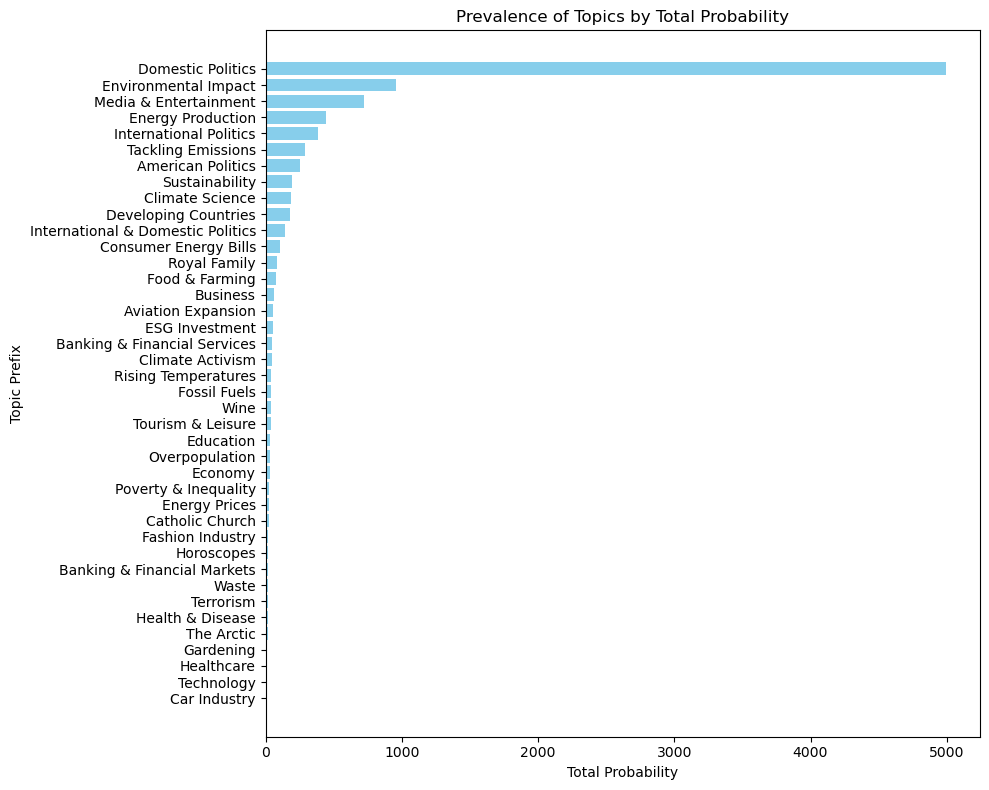

In [38]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_prefix_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_prefix = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_prefix = topic_name.split(':')[0].strip()

                if current_topic_prefix.startswith("Topic Excluded"):
                    current_topic_prefix = None 
            elif line.startswith("Probabilities:") and current_topic_prefix:
                probability = float(line.split(":")[1].strip())
                topic_prefix_totals[current_topic_prefix] += probability
    
    return topic_prefix_totals

def aggregate_probabilities(base_folder, orientations, periods):
    aggregated_totals = defaultdict(float)
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_prefix_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for prefix, total in topic_prefix_totals.items():
                aggregated_totals[prefix] += total
    
    return aggregated_totals

def plot_topic_prevalence(aggregated_totals):
    sorted_topics = sorted(aggregated_totals.items(), key=lambda x: x[1], reverse=True)
    topics, probabilities = zip(*sorted_topics)
    

    plt.figure(figsize=(10, 8))
    plt.barh(topics, probabilities, color='skyblue')
    plt.xlabel('Total Probability')
    plt.ylabel('Topic Prefix')
    plt.title('Prevalence of Topics by Total Probability')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

def process_and_visualize(base_folder, orientations, periods):
    aggregated_totals = aggregate_probabilities(base_folder, orientations, periods)
    plot_topic_prevalence(aggregated_totals)

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

process_and_visualize(base_folder, orientations, periods)


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


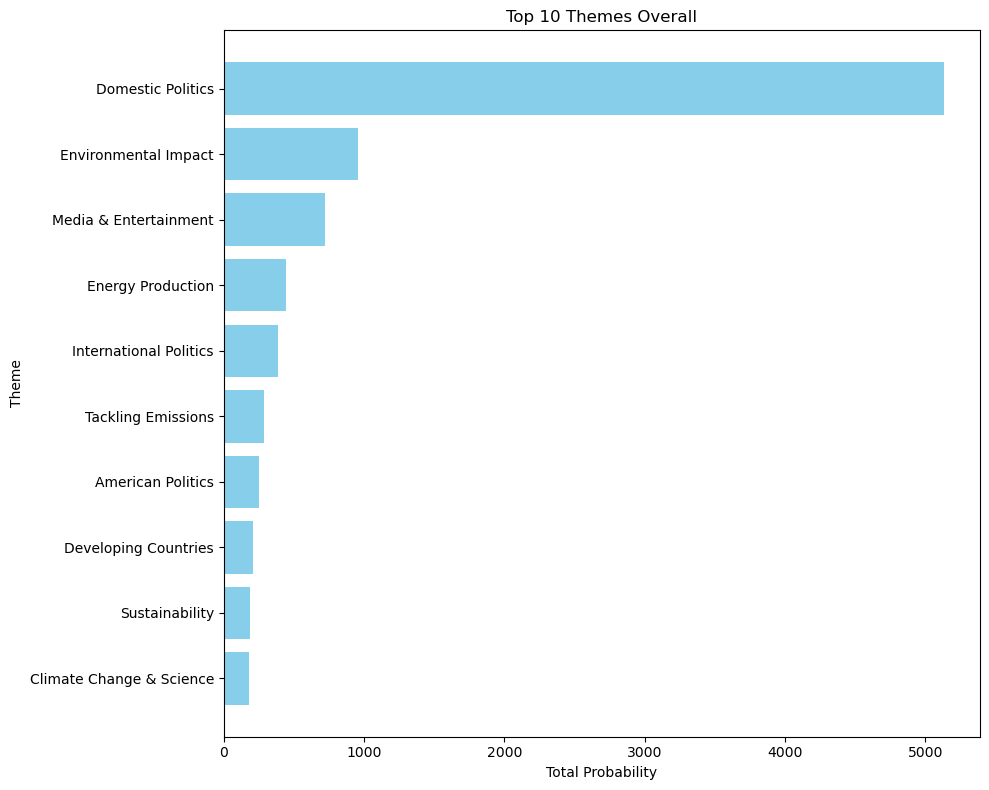

In [11]:

def get_topic_themes():
    return {
        "American Politics": ["American Politics", "American Politics: Keystone Pipeline", "American Politics: Obama Presidency", "American Politics: US Election"],
        "Aviation": ["Aviation Expansion"],
        "Banking & Finance": ["Banking & Financial Markets", "Banking & Financial Services"],
        "Business": ["Business", "Sustainability: Business"],
        "Climate Activism": ["Climate Activism: Protests", "Climate Activism: Protests Heathrow"],
        "Climate Change & Science": ["Climate Change", "Climate Science", "Climate Science: Against Climate Scepticism", "Climate Science: Scientific Consensus"],
        "Developing Countries": ["Developing Countries", "Developing Countries: Disease", "Developing Countries: Food & Farming", "Developing Countries: Foreign Aid", "Developing Countries: Investment"],
        "Domestic Politics": ["Domestic Politics", "Domestic Politics: Coalition Government", "Domestic Politics: Conservative Party", "Domestic Politics: Governments Spending", "Domestic Politics: UK Election", "Domestic Politics: UK/EU Relations"],
        "Energy Production": ["Energy Production", "Energy Production: Arctic Oil Exploration", "Energy Production: Coal", "Energy Production: Fracking", "Energy Production: Nuclear", "Energy Production: Renewables"],
        "Environmental Impact": ["Environmental Impact", "Environmental Impact: Atmospheric Change", "Environmental Impact: Ecosystem", "Environmental Impact: Flooding", "Environmental Impact: Ice Melting", "Environmental Impact: Marine Life", "Environmental Impact: Melting Ice"],
        "International Politics": ["International Politics", "International Politics: East Asia", "International Politics: Environmental Summit", "International Politics: Environmental Summits", "International Politics: Environmental Summmits", "International Politics: South Asia", "International Politics: War & Conflict", "International Politics: World Summits"],
        "Media & Entertainment": ["Media & Entertainment", "Media & Entertainment: Newspapers", "Media & Entertainment: Radio", "Media & Entertainment: Sport", "Media & Entertainment: TV Guide"],
        "Sustainability": ["Sustainability", "Sustainability: Business", "Sustainability: Consumer Behaviour", "Sustainability: Developing Countries"],
        "Tackling Emissions": ["Tackling Emissions", "Tackling Emissions: Households", "Tackling Emissions: Transport"],
    }

def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()
                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def group_topics_by_themes(topic_fullname_totals, topic_themes):
    theme_totals = defaultdict(float)
    
    for topic, total in topic_fullname_totals.items():
        for theme, related_topics in topic_themes.items():
            if any(rt in topic for rt in related_topics):
                theme_totals[theme] += total
    
    return theme_totals

def aggregate_probabilities_by_theme(base_folder, orientations, periods, topic_themes):
    aggregated_totals = defaultdict(float)
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            theme_totals = group_topics_by_themes(topic_fullname_totals, topic_themes)
            
            for theme, total in theme_totals.items():
                aggregated_totals[theme] += total
    
    return aggregated_totals

def plot_top_ten_themes(aggregated_totals):
    sorted_themes = sorted(aggregated_totals.items(), key=lambda x: x[1], reverse=True)[:10]
    themes, probabilities = zip(*sorted_themes)
    

    plt.figure(figsize=(10, 8))
    plt.barh(themes, probabilities, color='skyblue')
    plt.xlabel('Total Probability')
    plt.ylabel('Theme')
    plt.title('Top 10 Themes Overall')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

def process_and_visualize_top_ten_themes(base_folder, orientations, periods):
    topic_themes = get_topic_themes()
    aggregated_totals = aggregate_probabilities_by_theme(base_folder, orientations, periods, topic_themes)
    plot_top_ten_themes(aggregated_totals)

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

process_and_visualize_top_ten_themes(base_folder, orientations, periods)


In [27]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_prefix_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_prefix = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_prefix = topic_name.split(':')[0].strip()

                if current_topic_prefix.startswith("Topic Excluded"):
                    current_topic_prefix = None  
            elif line.startswith("Probabilities:") and current_topic_prefix:
                probability = float(line.split(":")[1].strip())
                topic_prefix_totals[current_topic_prefix] += probability
    
    return topic_prefix_totals

def get_unique_topics_with_probabilities(base_folder, orientations, periods):
    orientation_topics = {orientation: {} for orientation in orientations}
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_prefix_totals = parse_topic_distribution_file(topic_distribution_file)
            orientation_topics[orientation][period] = topic_prefix_totals
    

    unique_topics_data = []

    for period in periods:
        centre_left_topics = set(orientation_topics['centre-left'][period].keys())
        centre_right_topics = set(orientation_topics['centre-right'][period].keys())
        
        unique_centre_left_topics = centre_left_topics - centre_right_topics
        unique_centre_right_topics = centre_right_topics - centre_left_topics
        
        for topic in unique_centre_left_topics:
            unique_topics_data.append({
                'Period': period,
                'Topic': topic,
                'Centre-Left Probability': orientation_topics['centre-left'][period].get(topic, 0.0),
                'Centre-Right Probability': 0.0
            })
        
        for topic in unique_centre_right_topics:
            unique_topics_data.append({
                'Period': period,
                'Topic': topic,
                'Centre-Left Probability': 0.0,
                'Centre-Right Probability': orientation_topics['centre-right'][period].get(topic, 0.0)
            })

    return pd.DataFrame(unique_topics_data)

def process_and_output_unique_topics(base_folder, output_file):
    orientations = ['centre-left', 'centre-right']
    periods = ['1998-2007', '2008-2016']

 
    unique_topics_df = get_unique_topics_with_probabilities(base_folder, orientations, periods)


    unique_topics_df.to_csv(output_file, index=False)
    print(f"Unique topics table saved to {output_file}")


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
output_file = r'/Users/mty925/Documents/Dissertation/unique_topics_last_two_periods.csv'

process_and_output_unique_topics(base_folder, output_file)


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...
Unique topics table saved to /Users/mty925/Documents/Dissertation/unique_topics_last_two_periods.csv


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


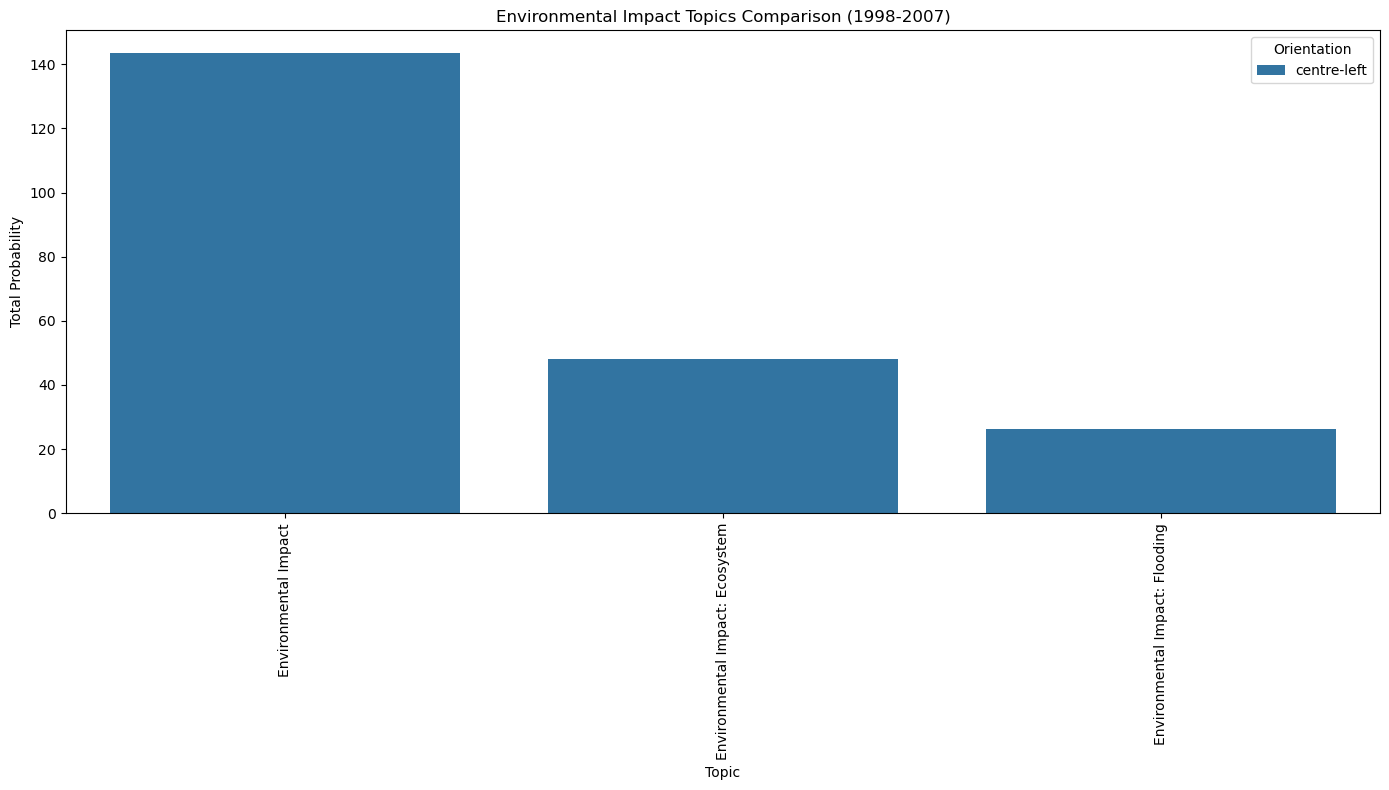

In [22]:
def normalize_topic_name(topic_name):
    #correcting naming mistake
    if topic_name in ["Environmental Impact: Ice Melting", "Environmental Impact: Melting Ice"]:
        return "Environmental Impact: Ice Melting"
    elif topic_name in ["Environmental Impact: Marine Life", "Environmental Impact: Marine Life' -"]:
        return "Environmental Impact: Marine Life"
    return topic_name

def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = normalize_topic_name(topic_name.strip())


                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None 
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def get_environmental_impact_topics(base_folder, orientations, periods, env_prefix):
    env_topics_data = []

    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, probability in topic_fullname_totals.items():
                if topic.lower().startswith(env_prefix.lower()):
                    env_topics_data.append({
                        'Period': period,
                        'Topic': topic,
                        'Orientation': orientation,
                        'Probability': probability
                    })

    return pd.DataFrame(env_topics_data)

def plot_environmental_impact_comparison(env_topics_df):
    periods = env_topics_df['Period'].unique()
    
    for period in periods:
        period_df = env_topics_df[env_topics_df['Period'] == period]
        
        
        plt.figure(figsize=(14, 8))
        sns.barplot(data=period_df, x='Topic', y='Probability', hue='Orientation', dodge=True)
        
        plt.title(f'Environmental Impact Topics Comparison ({period})')
        plt.xlabel('Topic')
        plt.ylabel('Total Probability')
        plt.xticks(rotation=90)
        plt.legend(title='Orientation')
        plt.tight_layout()
        
    
        plt.show()


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'


env_prefix = 'environmental impact'


orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']


env_topics_df = get_environmental_impact_topics(base_folder, orientations, periods, env_prefix)


plot_environmental_impact_comparison(env_topics_df)


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


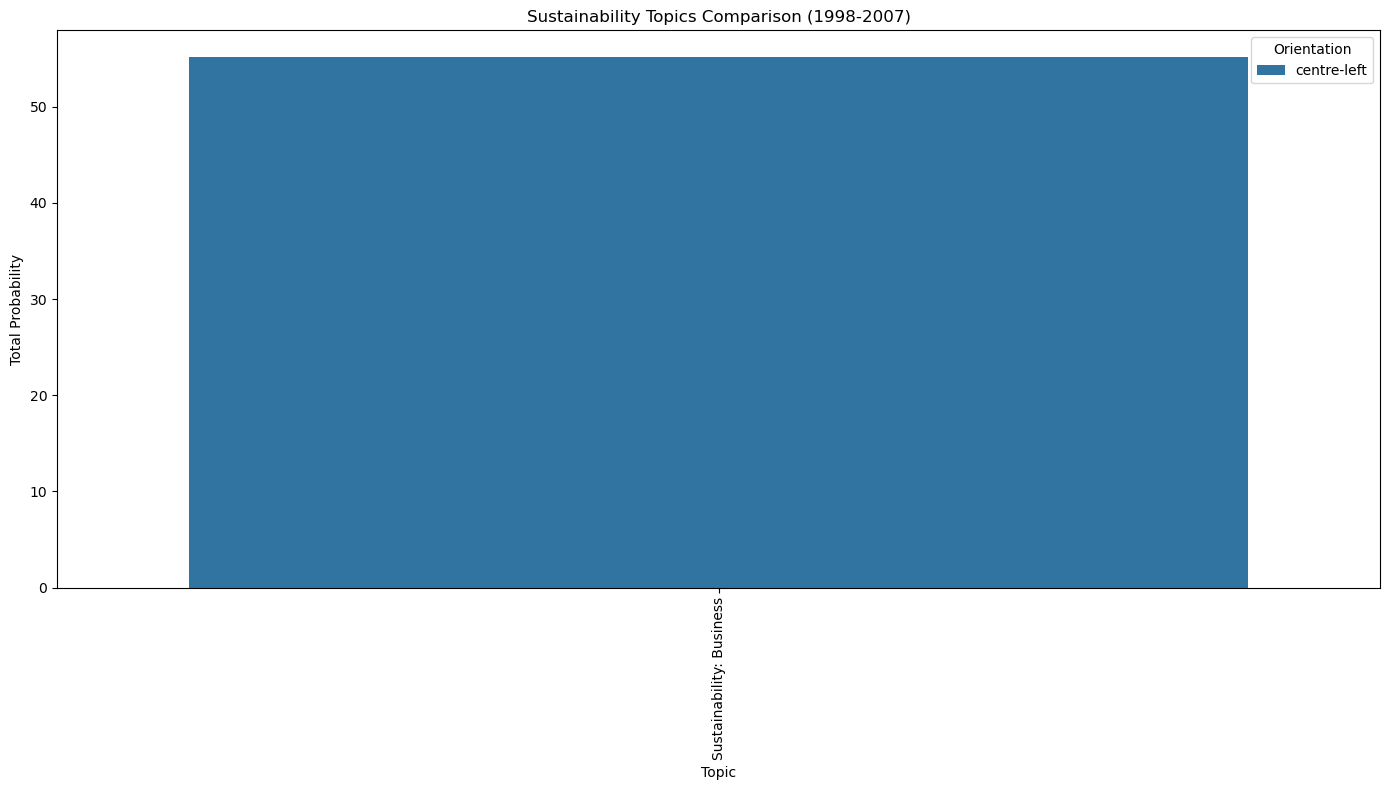

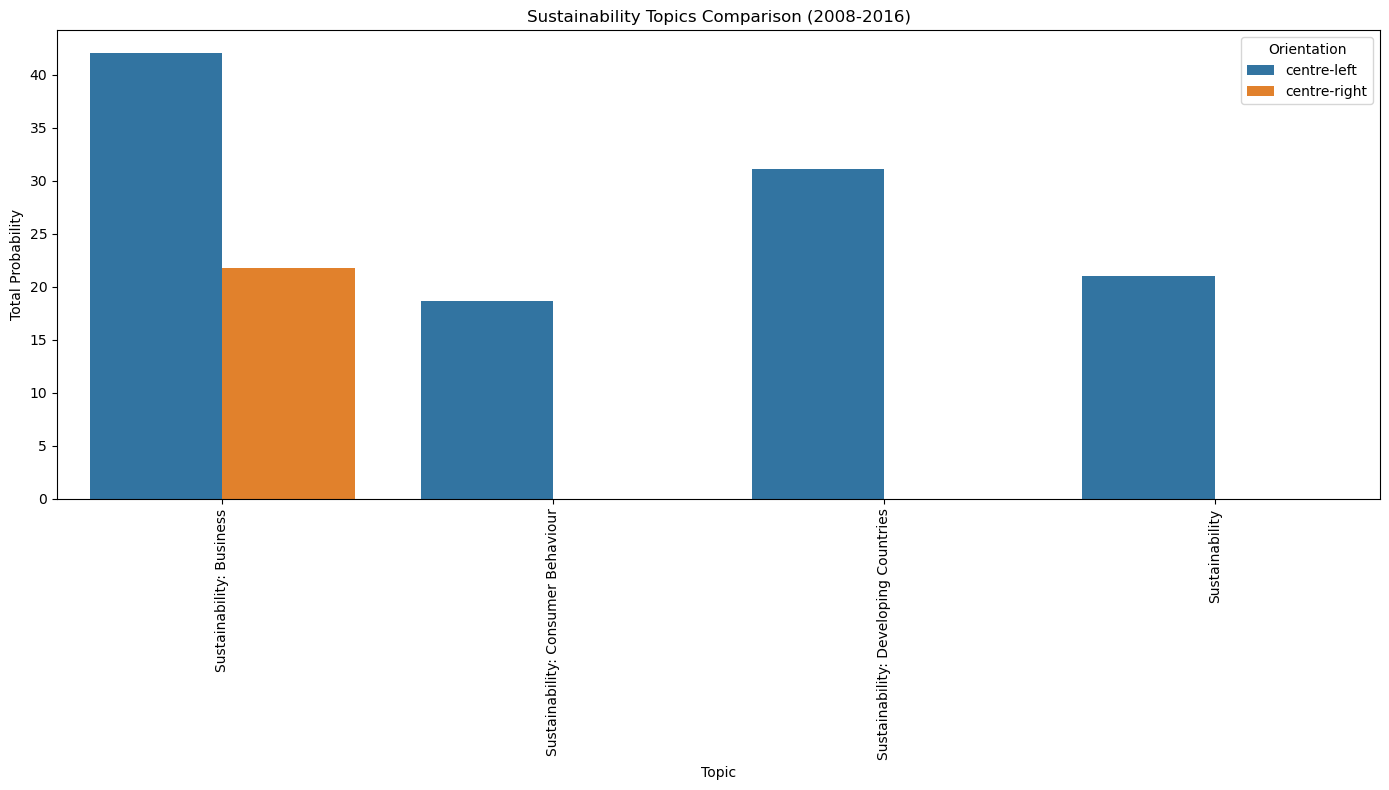

In [23]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()


                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None  
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def get_environmental_impact_topics(base_folder, orientations, periods, env_prefix):
    env_topics_data = []

    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, probability in topic_fullname_totals.items():
                if topic.lower().startswith(env_prefix.lower()):
                    env_topics_data.append({
                        'Period': period,
                        'Topic': topic,
                        'Orientation': orientation,
                        'Probability': probability
                    })

    return pd.DataFrame(env_topics_data)

def plot_environmental_impact_comparison(env_topics_df):
    periods = env_topics_df['Period'].unique()
    
    for period in periods:
        period_df = env_topics_df[env_topics_df['Period'] == period]
        
        plt.figure(figsize=(14, 8))
        sns.barplot(data=period_df, x='Topic', y='Probability', hue='Orientation', dodge=True)
        
        plt.title(f'Sustainability Topics Comparison ({period})')
        plt.xlabel('Topic')
        plt.ylabel('Total Probability')
        plt.xticks(rotation=90)
        plt.legend(title='Orientation')
        plt.tight_layout()
        
        plt.show()


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'


env_prefix = 'sustainability'


orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']


env_topics_df = get_environmental_impact_topics(base_folder, orientations, periods, env_prefix)


plot_environmental_impact_comparison(env_topics_df)


In [17]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
       
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()
                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None 
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def get_environmental_impact_topics(base_folder, orientations, periods, env_prefix):
    env_topics_data = []

    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, probability in topic_fullname_totals.items():
                if topic.lower().startswith(env_prefix.lower()):
                    env_topics_data.append({
                        'Period': period,
                        'Topic': topic,
                        'Orientation': orientation,
                        'Probability': probability
                    })

    return pd.DataFrame(env_topics_data)

def plot_environmental_impact_comparison(env_topics_df):
    periods = env_topics_df['Period'].unique()
    
    for period in periods:
        period_df = env_topics_df[env_topics_df['Period'] == period]
        

        plt.figure(figsize=(14, 8))
        sns.barplot(data=period_df, x='Topic', y='Probability', hue='Orientation', dodge=True)
        
        plt.title(f'Developing Countries Topics Comparison ({period})')
        plt.xlabel('Topic')
        plt.ylabel('Total Probability')
        plt.xticks(rotation=90)
        plt.legend(title='Orientation')
        plt.tight_layout()
        

        plt.show()


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'


env_prefix = 'developing countries'

orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']


env_topics_df = get_environmental_impact_topics(base_folder, orientations, periods, env_prefix)


plot_environmental_impact_comparison(env_topics_df)


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


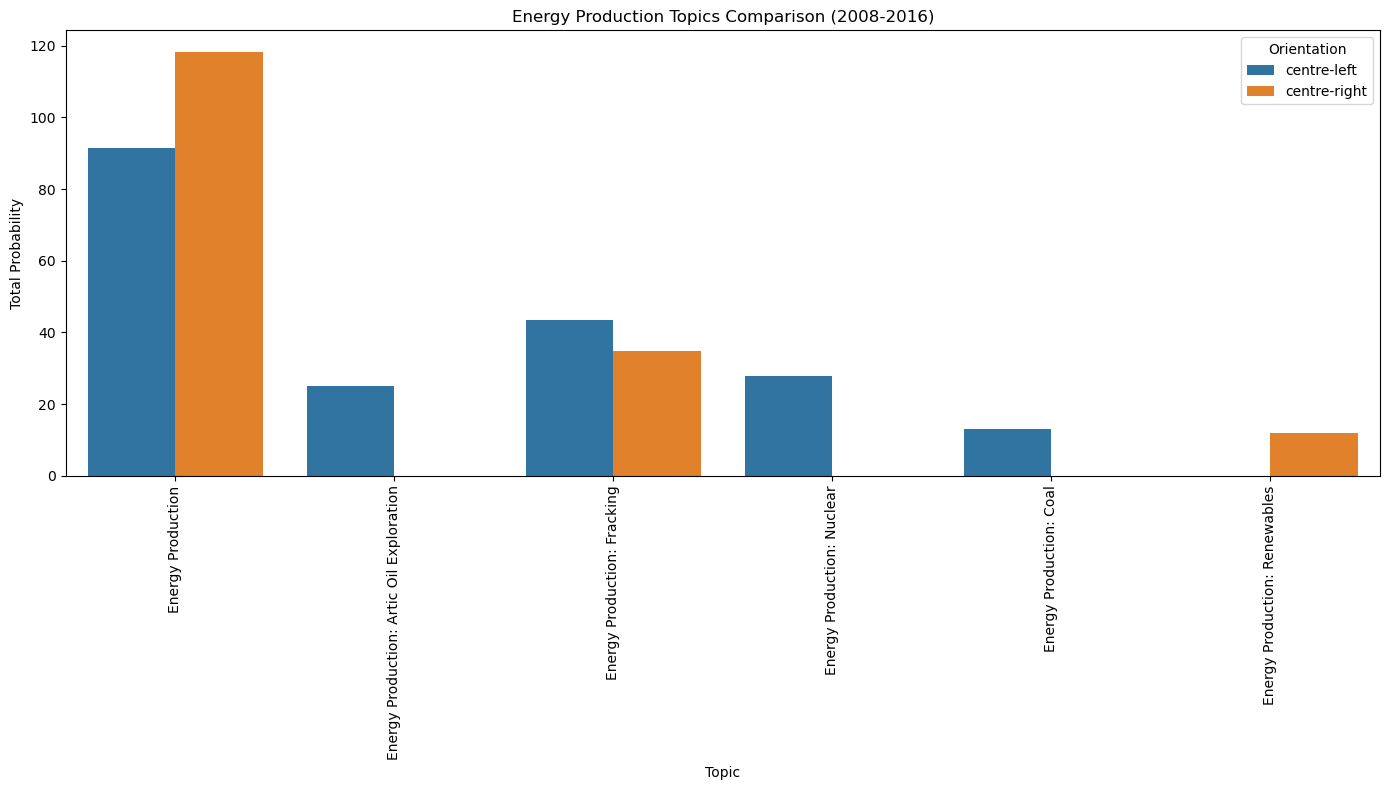

In [18]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()

               
                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None  
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def get_environmental_impact_topics(base_folder, orientations, periods, env_prefix):
    env_topics_data = []

    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, probability in topic_fullname_totals.items():
                if topic.lower().startswith(env_prefix.lower()):
                    env_topics_data.append({
                        'Period': period,
                        'Topic': topic,
                        'Orientation': orientation,
                        'Probability': probability
                    })

    return pd.DataFrame(env_topics_data)

def plot_environmental_impact_comparison(env_topics_df):
    periods = env_topics_df['Period'].unique()
    
    for period in periods:
        period_df = env_topics_df[env_topics_df['Period'] == period]
        

        plt.figure(figsize=(14, 8))
        sns.barplot(data=period_df, x='Topic', y='Probability', hue='Orientation', dodge=True)
        
        plt.title(f'Energy Production Topics Comparison ({period})')
        plt.xlabel('Topic')
        plt.ylabel('Total Probability')
        plt.xticks(rotation=90)
        plt.legend(title='Orientation')
        plt.tight_layout()
        

        plt.show()


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'


env_prefix = 'energy production'


orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']


env_topics_df = get_environmental_impact_topics(base_folder, orientations, periods, env_prefix)


plot_environmental_impact_comparison(env_topics_df)


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


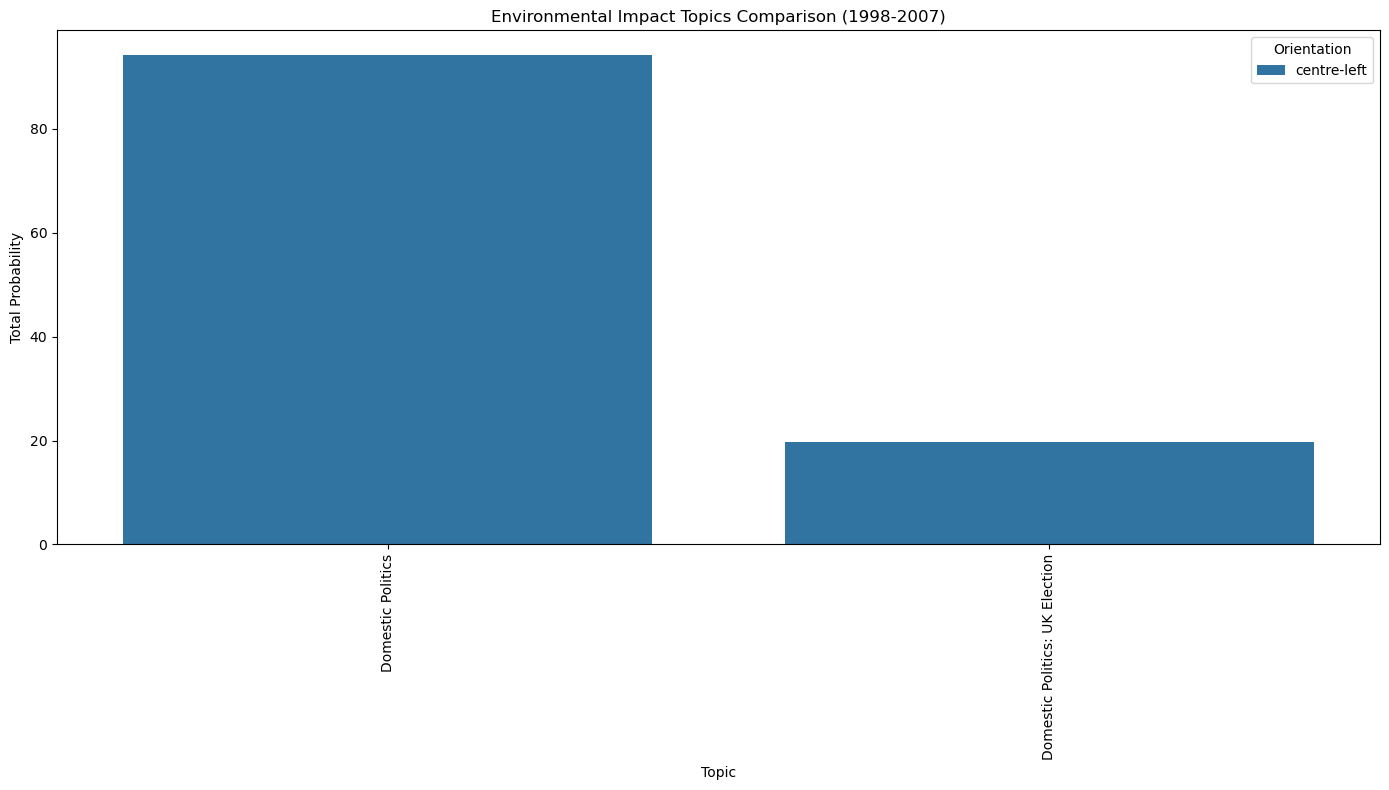

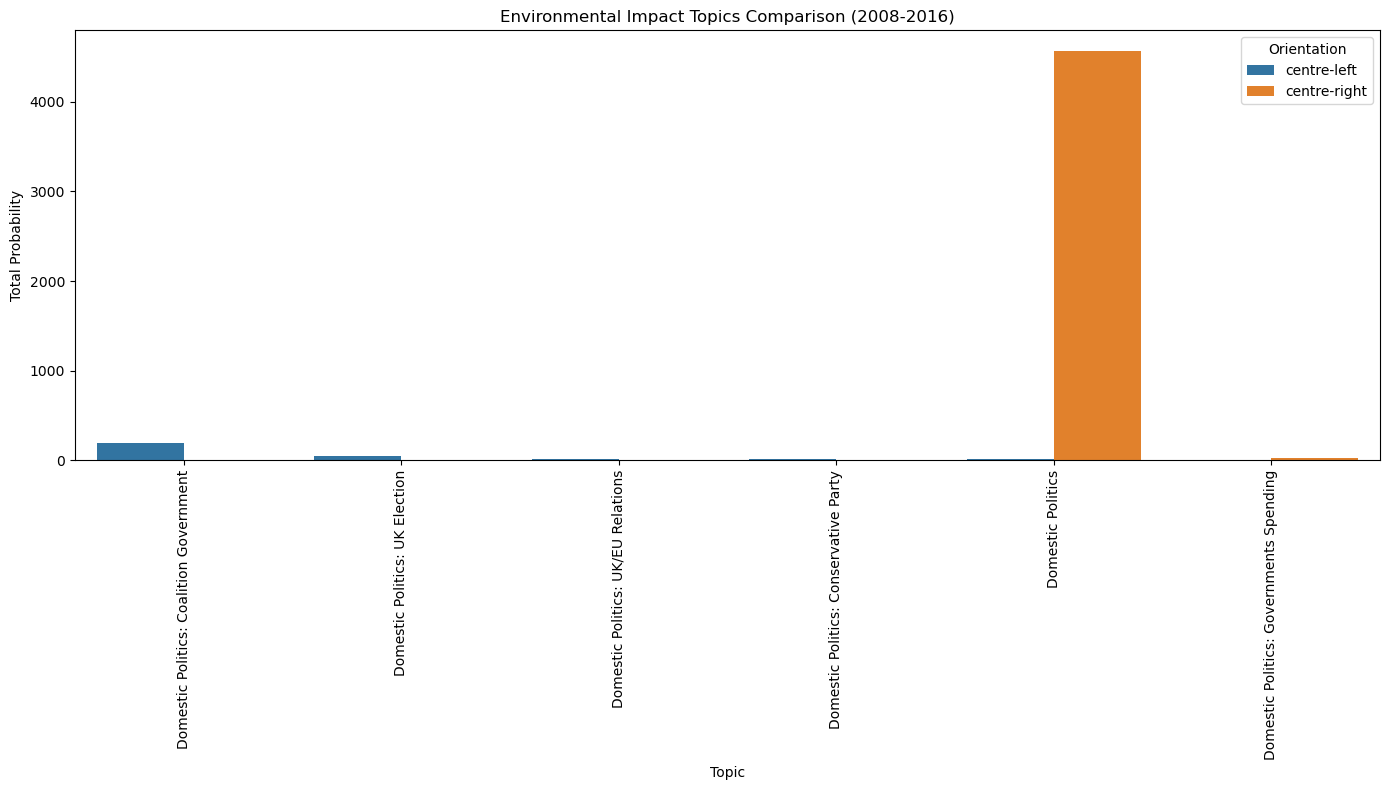

In [34]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()

                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None  
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def get_environmental_impact_topics(base_folder, orientations, periods, env_prefix):
    env_topics_data = []

    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, probability in topic_fullname_totals.items():
                if topic.lower().startswith(env_prefix.lower()):
                    env_topics_data.append({
                        'Period': period,
                        'Topic': topic,
                        'Orientation': orientation,
                        'Probability': probability
                    })

    return pd.DataFrame(env_topics_data)

def plot_environmental_impact_comparison(env_topics_df):
    periods = env_topics_df['Period'].unique()
    
    for period in periods:
        period_df = env_topics_df[env_topics_df['Period'] == period]
        
        plt.figure(figsize=(14, 8))
        sns.barplot(data=period_df, x='Topic', y='Probability', hue='Orientation', dodge=True)
        
        plt.title(f'Environmental Impact Topics Comparison ({period})')
        plt.xlabel('Topic')
        plt.ylabel('Total Probability')
        plt.xticks(rotation=90)
        plt.legend(title='Orientation')
        plt.tight_layout()
        
        plt.show()

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'


env_prefix = 'domestic politics'

orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

env_topics_df = get_environmental_impact_topics(base_folder, orientations, periods, env_prefix)

plot_environmental_impact_comparison(env_topics_df)


Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


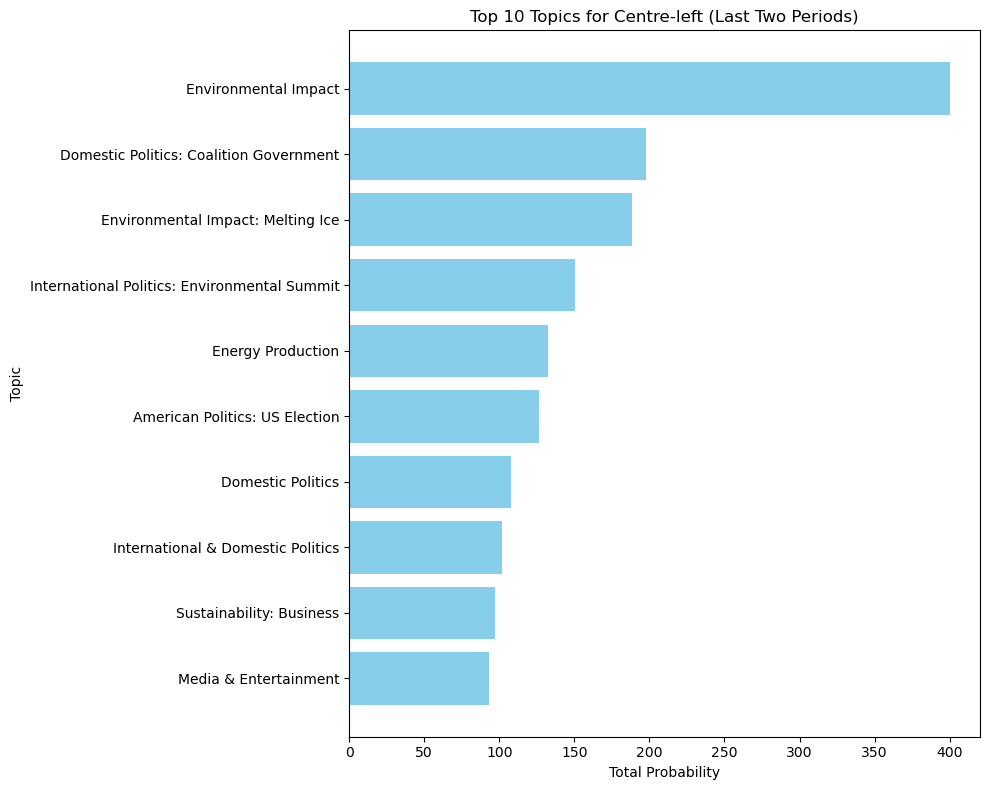

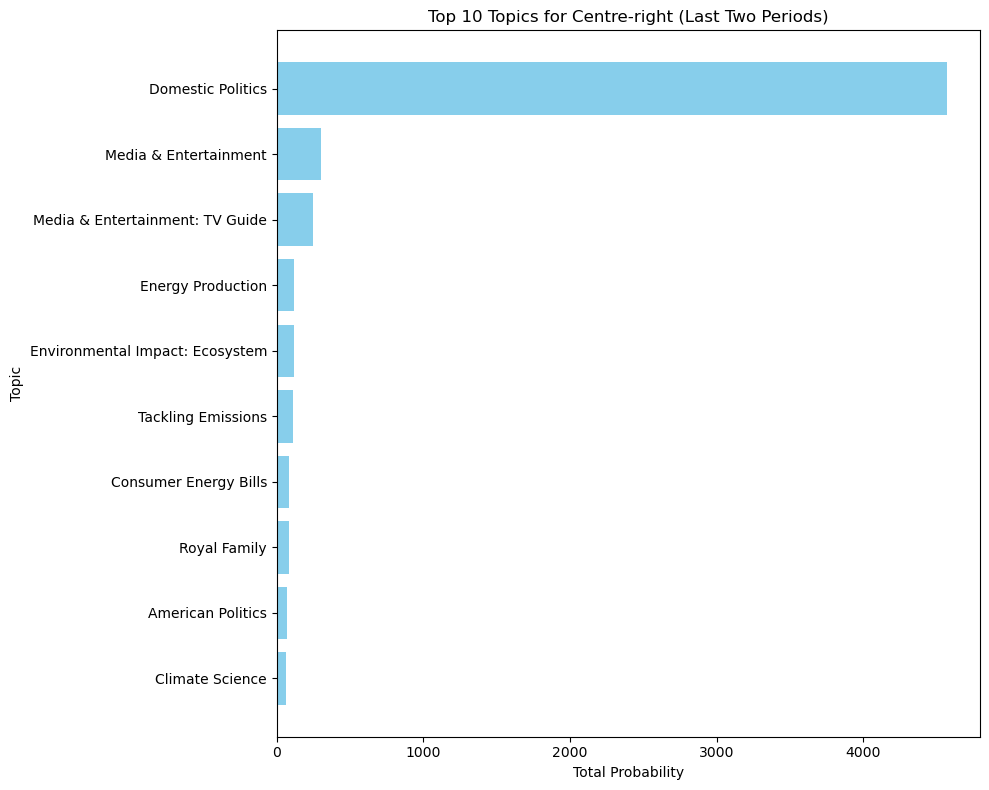

In [30]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()

                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None  
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def aggregate_probabilities(base_folder, orientations, periods):
    aggregated_totals = defaultdict(lambda: defaultdict(float))
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, total in topic_fullname_totals.items():
                aggregated_totals[orientation][topic] += total
    
    return aggregated_totals

def plot_top_ten_topics(aggregated_totals, orientation, title):
    sorted_topics = sorted(aggregated_totals[orientation].items(), key=lambda x: x[1], reverse=True)[:10]
    topics, probabilities = zip(*sorted_topics)
    
    plt.figure(figsize=(10, 8))
    plt.barh(topics, probabilities, color='skyblue')
    plt.xlabel('Total Probability')
    plt.ylabel('Topic')
    plt.title(f'Top 10 Topics for {orientation.capitalize()} ({title})')
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.show()

def process_and_visualize_top_ten(base_folder, orientations, periods):
    aggregated_totals = aggregate_probabilities(base_folder, orientations, periods)
    
    for orientation in orientations:
        plot_top_ten_topics(aggregated_totals, orientation, title="Last Two Periods")


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

process_and_visualize_top_ten(base_folder, orientations, periods)


In [ ]:
Visualisations using document count 

Aggregating document counts for centre-left during 1998-2007...
Aggregating document counts for centre-left during 2008-2016...
Aggregating document counts for centre-right during 1998-2007...
Aggregating document counts for centre-right during 2008-2016...


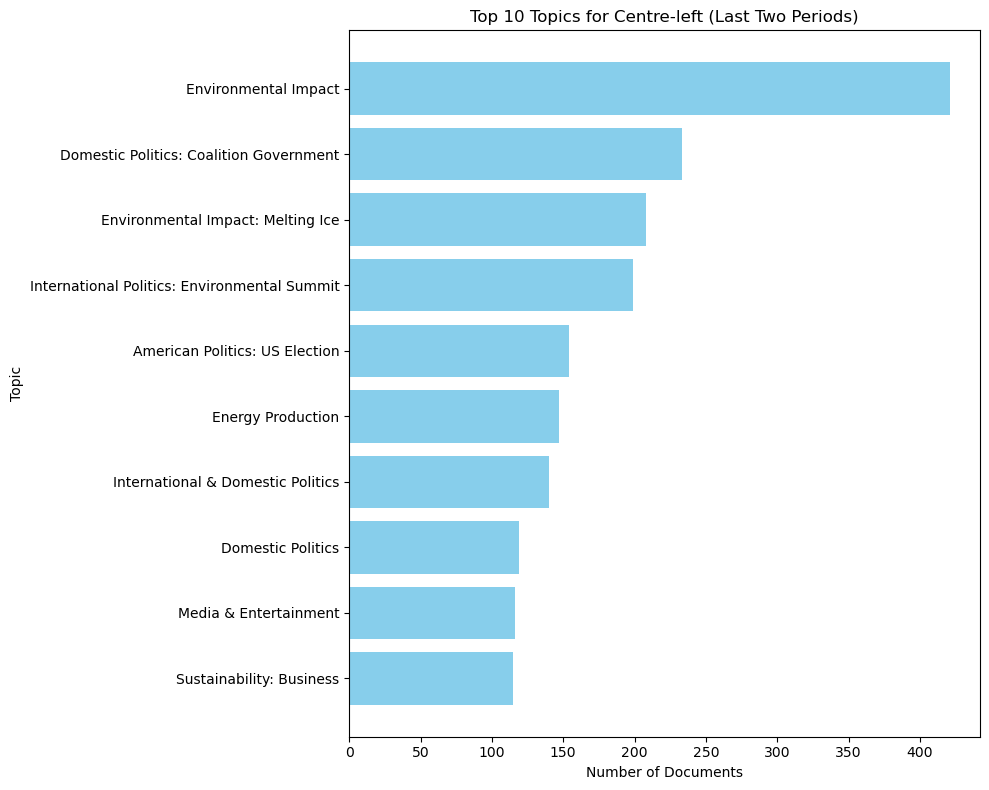

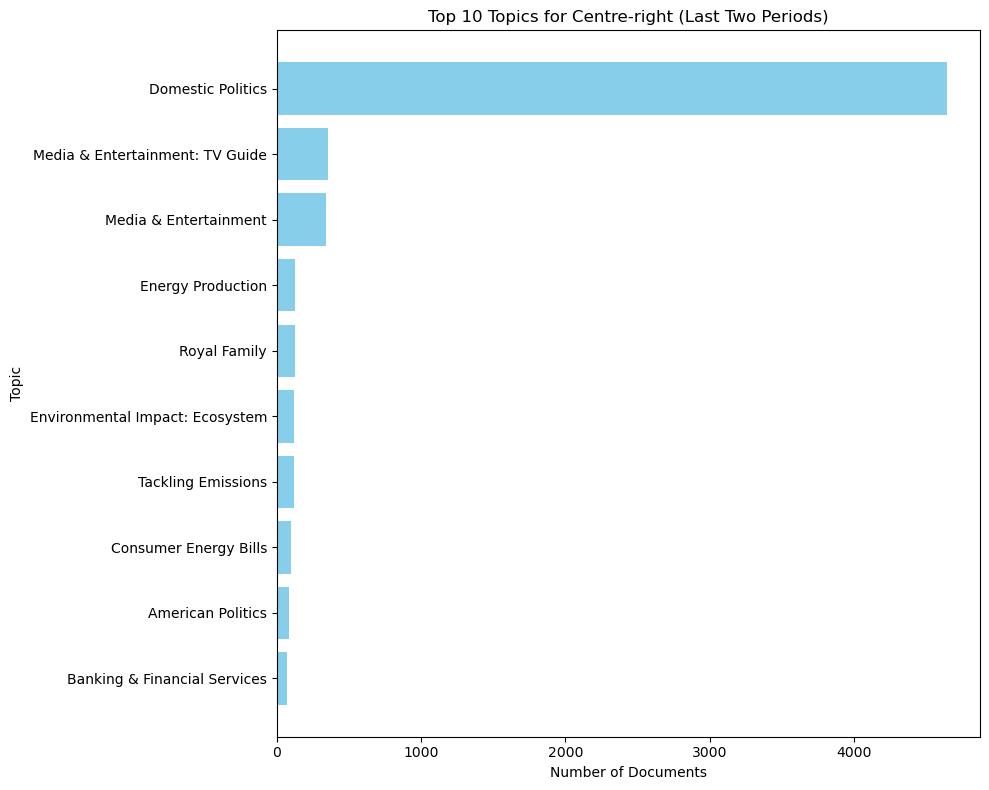

In [35]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_document_count = defaultdict(int)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()

                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None  
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                if probability > 0:
                    topic_document_count[current_topic_fullname] += 1
    
    return topic_document_count

def aggregate_document_counts(base_folder, orientations, periods):
    aggregated_totals = defaultdict(lambda: defaultdict(int))
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating document counts for {orientation} during {period}...")
            topic_document_count = parse_topic_distribution_file(topic_distribution_file)
            
            for topic, count in topic_document_count.items():
                aggregated_totals[orientation][topic] += count
    
    return aggregated_totals

def plot_top_ten_topics(aggregated_totals, orientation, title):
    sorted_topics = sorted(aggregated_totals[orientation].items(), key=lambda x: x[1], reverse=True)[:10]
    topics, counts = zip(*sorted_topics)
    
    plt.figure(figsize=(10, 8))
    plt.barh(topics, counts, color='skyblue')
    plt.xlabel('Number of Documents')
    plt.ylabel('Topic')
    plt.title(f'Top 10 Topics for {orientation.capitalize()} ({title})')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

def process_and_visualize_top_ten(base_folder, orientations, periods):
    aggregated_totals = aggregate_document_counts(base_folder, orientations, periods)
    
    for orientation in orientations:
        plot_top_ten_topics(aggregated_totals, orientation, title="Last Two Periods")

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

process_and_visualize_top_ten(base_folder, orientations, periods)


Aggregating document counts for centre-left during 1998-2007...
Aggregating document counts for centre-left during 2008-2016...
Aggregating document counts for centre-right during 1998-2007...
Aggregating document counts for centre-right during 2008-2016...


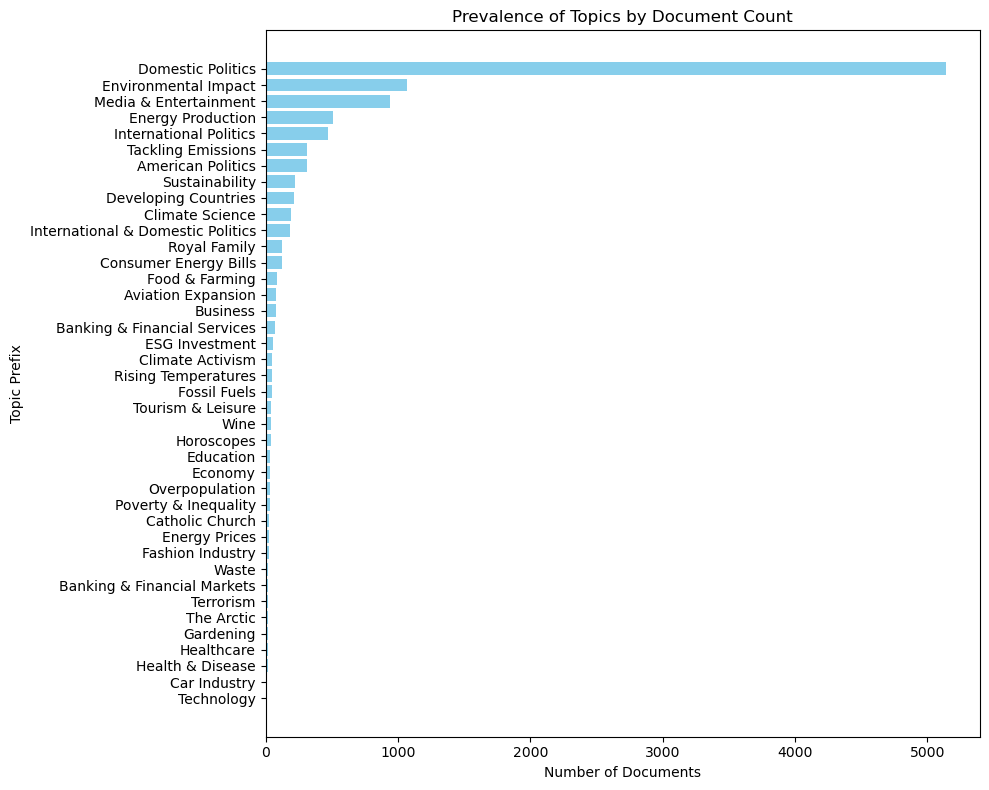

In [37]:
def parse_topic_distribution_file(topic_distribution_file):
    topic_prefix_counts = defaultdict(int)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_prefix = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_prefix = topic_name.split(':')[0].strip()
                if current_topic_prefix.startswith("Topic Excluded"):
                    current_topic_prefix = None  
            elif line.startswith("Probabilities:") and current_topic_prefix:
                probability = float(line.split(":")[1].strip())
                if probability > 0:
                    topic_prefix_counts[current_topic_prefix] += 1
    
    return topic_prefix_counts

def aggregate_document_counts(base_folder, orientations, periods):
    aggregated_counts = defaultdict(int)
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating document counts for {orientation} during {period}...")
            topic_prefix_counts = parse_topic_distribution_file(topic_distribution_file)
            
            for prefix, count in topic_prefix_counts.items():
                aggregated_counts[prefix] += count
    
    return aggregated_counts

def plot_topic_prevalence(aggregated_counts):
    sorted_topics = sorted(aggregated_counts.items(), key=lambda x: x[1], reverse=True)
    topics, counts = zip(*sorted_topics)
    

    plt.figure(figsize=(10, 8))
    plt.barh(topics, counts, color='skyblue')
    plt.xlabel('Number of Documents')
    plt.ylabel('Topic Prefix')
    plt.title('Prevalence of Topics by Document Count')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

def process_and_visualize(base_folder, orientations, periods):
    aggregated_counts = aggregate_document_counts(base_folder, orientations, periods)
    plot_topic_prevalence(aggregated_counts)


base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

process_and_visualize(base_folder, orientations, periods)


In [39]:
def print_all_topics(base_folder, orientations, periods):
    all_topics = set()
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Extracting topics for {orientation} during {period}...")
            
            with open(topic_distribution_file, 'r', encoding='utf-8') as file:
                lines = file.readlines()
                
                for line in lines:
                    line = line.strip()
                    if line.startswith("Topic:"):
                        topic_name = line.split('"')[1].strip()
                        all_topics.add(topic_name)

    print("\nList of All Topics:")
    for topic in sorted(all_topics):
        print(topic)

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1988-1997', '1998-2007', '2008-2016']

print_all_topics(base_folder, orientations, periods)


Extracting topics for centre-left during 1988-1997...
Extracting topics for centre-left during 1998-2007...
Extracting topics for centre-left during 2008-2016...
Extracting topics for centre-right during 1988-1997...
Extracting topics for centre-right during 1998-2007...
Extracting topics for centre-right during 2008-2016...

List of All Topics:
American Politics
American Politics: Keystone Pipeline
American Politics: Obama Presidency
American Politics: US Election
Aviation Expansion
Banking & Financial Markets
Banking & Financial Services
Business
Car Industry
Catholic Church
Climate Activism: Protests
Climate Activism: Protests Heathrow
Climate Change
Climate Science
Climate Science: Against Climate Scepticism
Climate Science: Scientific Consensus
Consumer Energy Bills
Developing Countries
Developing Countries: Disease
Developing Countries: Food & Farming
Developing Countries: Foreign Aid
Developing Countries: Investment
Domestic Politics
Domestic Politics: Coalition Government
Domes

Aggregating probabilities for centre-left during 1998-2007...
Aggregating probabilities for centre-left during 2008-2016...
Aggregating probabilities for centre-right during 1998-2007...
Aggregating probabilities for centre-right during 2008-2016...


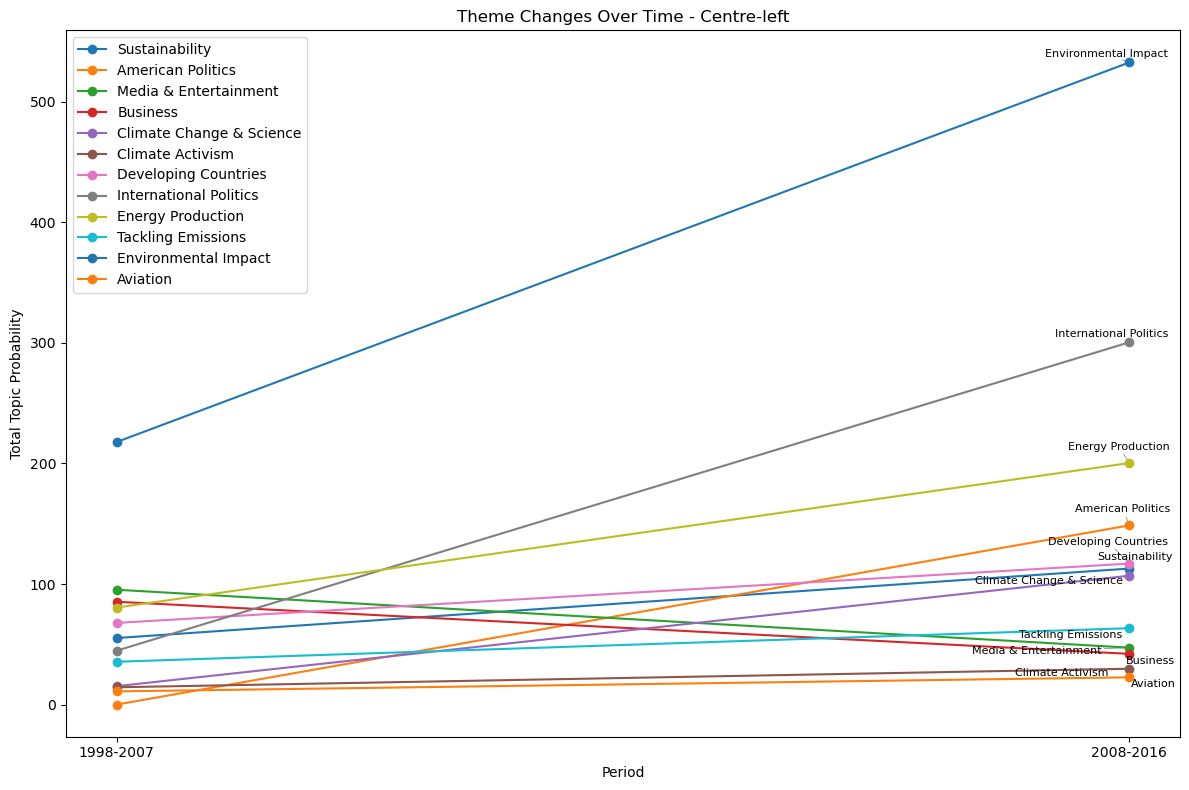

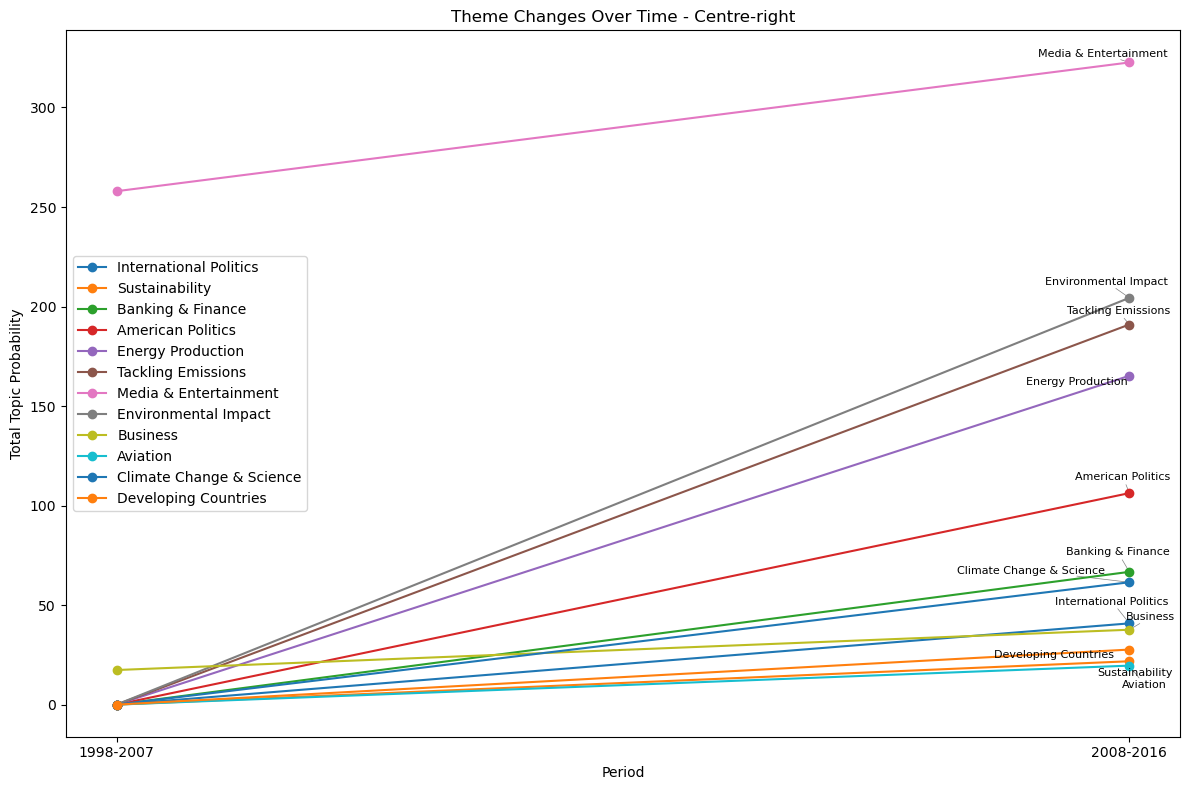

In [14]:
def get_topic_themes():
    return {
        "American Politics": ["American Politics", "American Politics: Keystone Pipeline", "American Politics: Obama Presidency", "American Politics: US Election"],
        "Aviation": ["Aviation Expansion"],
        "Banking & Finance": ["Banking & Financial Markets", "Banking & Financial Services"],
        "Business": ["Business", "Sustainability: Business"],
        "Climate Activism": ["Climate Activism: Protests", "Climate Activism: Protests Heathrow"],
        "Climate Change & Science": ["Climate Change", "Climate Science", "Climate Science: Against Climate Scepticism", "Climate Science: Scientific Consensus"],
        "Developing Countries": ["Developing Countries", "Developing Countries: Disease", "Developing Countries: Food & Farming", "Developing Countries: Foreign Aid", "Developing Countries: Investment"],
        "Energy Production": ["Energy Production", "Energy Production: Arctic Oil Exploration", "Energy Production: Coal", "Energy Production: Fracking", "Energy Production: Nuclear", "Energy Production: Renewables"],
        "Environmental Impact": ["Environmental Impact", "Environmental Impact: Atmospheric Change", "Environmental Impact: Ecosystem", "Environmental Impact: Flooding", "Environmental Impact: Ice Melting", "Environmental Impact: Marine Life", "Environmental Impact: Melting Ice"],
        "International Politics": ["International Politics", "International Politics: East Asia", "International Politics: Environmental Summit", "International Politics: Environmental Summits", "International Politics: Environmental Summmits", "International Politics: South Asia", "International Politics: War & Conflict", "International Politics: World Summits"],
        "Media & Entertainment": ["Media & Entertainment", "Media & Entertainment: Newspapers", "Media & Entertainment: Radio", "Media & Entertainment: Sport", "Media & Entertainment: TV Guide"],
        "Sustainability": ["Sustainability", "Sustainability: Business", "Sustainability: Consumer Behaviour", "Sustainability: Developing Countries"],
        "Tackling Emissions": ["Tackling Emissions", "Tackling Emissions: Households", "Tackling Emissions: Transport"],
    }

def parse_topic_distribution_file(topic_distribution_file):
    topic_fullname_totals = defaultdict(float)
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()
                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                topic_fullname_totals[current_topic_fullname] += probability
    
    return topic_fullname_totals

def group_topics_by_themes(topic_fullname_totals, topic_themes):
    theme_totals = defaultdict(float)
    
    for topic, total in topic_fullname_totals.items():
        for theme, related_topics in topic_themes.items():
            if any(rt in topic for rt in related_topics):
                theme_totals[theme] += total
    
    return theme_totals

def aggregate_probabilities_by_theme(base_folder, orientations, periods, topic_themes):
    aggregated_totals = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Aggregating probabilities for {orientation} during {period}...")
            topic_fullname_totals = parse_topic_distribution_file(topic_distribution_file)
            theme_totals = group_topics_by_themes(topic_fullname_totals, topic_themes)
            
            for theme, total in theme_totals.items():
                aggregated_totals[orientation][period][theme] += total
    
    return aggregated_totals

def plot_theme_changes(aggregated_totals, orientation):
    periods = list(aggregated_totals[orientation].keys())
    themes = list(set().union(*[set(aggregated_totals[orientation][period].keys()) for period in periods]))
    
    plt.figure(figsize=(12, 8))
    texts = []
    for theme in themes:
        period_data = [aggregated_totals[orientation][period].get(theme, 0) for period in periods]
        plt.plot(periods, period_data, marker='o', label=theme)
        texts.append(plt.text(periods[-1], period_data[-1], theme, fontsize=8, verticalalignment='bottom', horizontalalignment='left'))
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
    plt.xlabel('Period')
    plt.ylabel('Total Topic Probability')
    plt.title(f'Theme Changes Over Time - {orientation.capitalize()}')
    plt.legend(loc='best') 
    plt.tight_layout()
    plt.show()

def process_and_visualize_theme_changes(base_folder, orientations, periods):
    topic_themes = get_topic_themes()
    aggregated_totals = aggregate_probabilities_by_theme(base_folder, orientations, periods, topic_themes)
    
    for orientation in orientations:
        plot_theme_changes(aggregated_totals, orientation)

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

process_and_visualize_theme_changes(base_folder, orientations, periods)


In [12]:
def parse_topic_distribution_file(topic_distribution_file):
    topics = set()
    
    with open(topic_distribution_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        current_topic_fullname = None
        
        for line in lines:
            line = line.strip()
            if line.startswith("Topic:"):
                topic_name = line.split('"')[1].strip()
                current_topic_fullname = topic_name.strip()
                if current_topic_fullname.startswith("Topic Excluded"):
                    current_topic_fullname = None
            elif line.startswith("Probabilities:") and current_topic_fullname:
                probability = float(line.split(":")[1].strip())
                if probability > 0:
                    topics.add(current_topic_fullname)
    
    return topics

def find_unique_topics(base_folder, orientations, periods):
    orientation_topics = defaultdict(set)
    
    for orientation in orientations:
        for period in periods:
            topic_distribution_file = os.path.join(base_folder, f'topic_distribution_{orientation}_{period}.txt')
            
            if not os.path.exists(topic_distribution_file):
                print(f"Topic distribution file not found: {topic_distribution_file}. Skipping...")
                continue
            
            print(f"Finding topics for {orientation} during {period}...")
            topics = parse_topic_distribution_file(topic_distribution_file)
            orientation_topics[orientation].update(topics)
    
    return orientation_topics

def print_unique_topics_table(orientation_topics):
    left_topics = orientation_topics['centre-left']
    right_topics = orientation_topics['centre-right']
    
    unique_left = left_topics - right_topics
    unique_right = right_topics - left_topics
    
    print("Unique Topics Table:")
    print(f"{'Unique to Centre-Left':<50} {'Unique to Centre-Right':<50}")
    print("="*100)
    
    max_len = max(len(unique_left), len(unique_right))
    unique_left = list(unique_left)
    unique_right = list(unique_right)
    
    for i in range(max_len):
        left_topic = unique_left[i] if i < len(unique_left) else ""
        right_topic = unique_right[i] if i < len(unique_right) else ""
        print(f"{left_topic:<50} {right_topic:<50}")

base_folder = r'/Users/mty925/Documents/Dissertation/climate_bert_embeddings'
orientations = ['centre-left', 'centre-right']
periods = ['1998-2007', '2008-2016']

orientation_topics = find_unique_topics(base_folder, orientations, periods)
print_unique_topics_table(orientation_topics)


Finding topics for centre-left during 1998-2007...
Finding topics for centre-left during 2008-2016...
Finding topics for centre-right during 1998-2007...
Finding topics for centre-right during 2008-2016...
Unique Topics Table:
Unique to Centre-Left                              Unique to Centre-Right                            
Sustainability                                     Overpopulation                                    
Energy Production: Nuclear                         American Politics                                 
Environmental Impact: Marine Life                  Media & Entertainment: TV Guide                   
American Politics: Keystone Pipeline               Environmental Impact: Ice Melting                 
Car Industry                                       Horoscopes                                        
International Politics: Environmental Summit       Waste                                             
Terrorism: Paris Attacks                           Banking 